In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff

Downlaod df_train

In [3]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
df_train = data.sample(20000)

In [5]:
#Basics statistics
print("Number of rows : {}".format(df_train.shape[0]))
print()

print("Display of dataset: ")
display(df_train.head())
print()

print("Basics statistics: ")
data_desc = df_train.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df_train.isnull().sum()/df_train.shape[0])

Number of rows : 20000

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
75554,US,24,0,Direct,1,0
209519,US,29,1,Seo,3,0
146351,US,32,0,Seo,8,0
67397,US,38,0,Direct,5,0
115669,US,24,1,Seo,1,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,20000,20000.000000,20000.000000,20000,20000.000000,20000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,11234,NaN,NaN,9789,NaN,NaN
mean,NaN,30.532700,0.683300,NaN,4.875250,0.031250
std,NaN,8.217756,0.465201,NaN,3.340231,0.173997
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

Downlaod df_test

In [6]:
df_test = pd.read_csv('conversion_data_test.csv')
print('Set with labels (our train+test) :', df_test.shape)

Set with labels (our train+test) : (31620, 5)


In [7]:
df_test['converted']= None

In [8]:
#Basics statistics
print("Number of rows : {}".format(df_test.shape[0]))
print()

print("Display of dataset: ")
display(df_test.head())
print()

print("Basics statistics: ")
data_desc = df_test.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df_test.isnull().sum()/df_test.shape[0])

Number of rows : 31620

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,UK,28,0,Seo,16,None
1,UK,22,1,Direct,5,None
2,China,32,1,Seo,1,None
3,US,32,1,Ads,6,None
4,China,25,0,Seo,3,None



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,31620,31620.000000,31620.000000,31620,31620.000000,0
unique,4,NaN,NaN,3,NaN,0
top,US,NaN,NaN,Seo,NaN,NaN
freq,17968,NaN,NaN,15563,NaN,NaN
mean,NaN,30.620746,0.685579,NaN,4.870398,NaN
std,NaN,8.316736,0.464292,NaN,3.333128,NaN
min,NaN,17.000000,0.000000,NaN,1.000000,NaN
25%,NaN,24.000000,0.000000,NaN,2.000000,NaN
50%,NaN,30.000000,1.000000,NaN,4.000000,NaN
75%,NaN,36.000000,1.000000,NaN,7.000000,NaN



Percentage of missing values: 


country                  0.0
age                      0.0
new_user                 0.0
source                   0.0
total_pages_visited      0.0
converted              100.0
dtype: float64

## 1- EDA

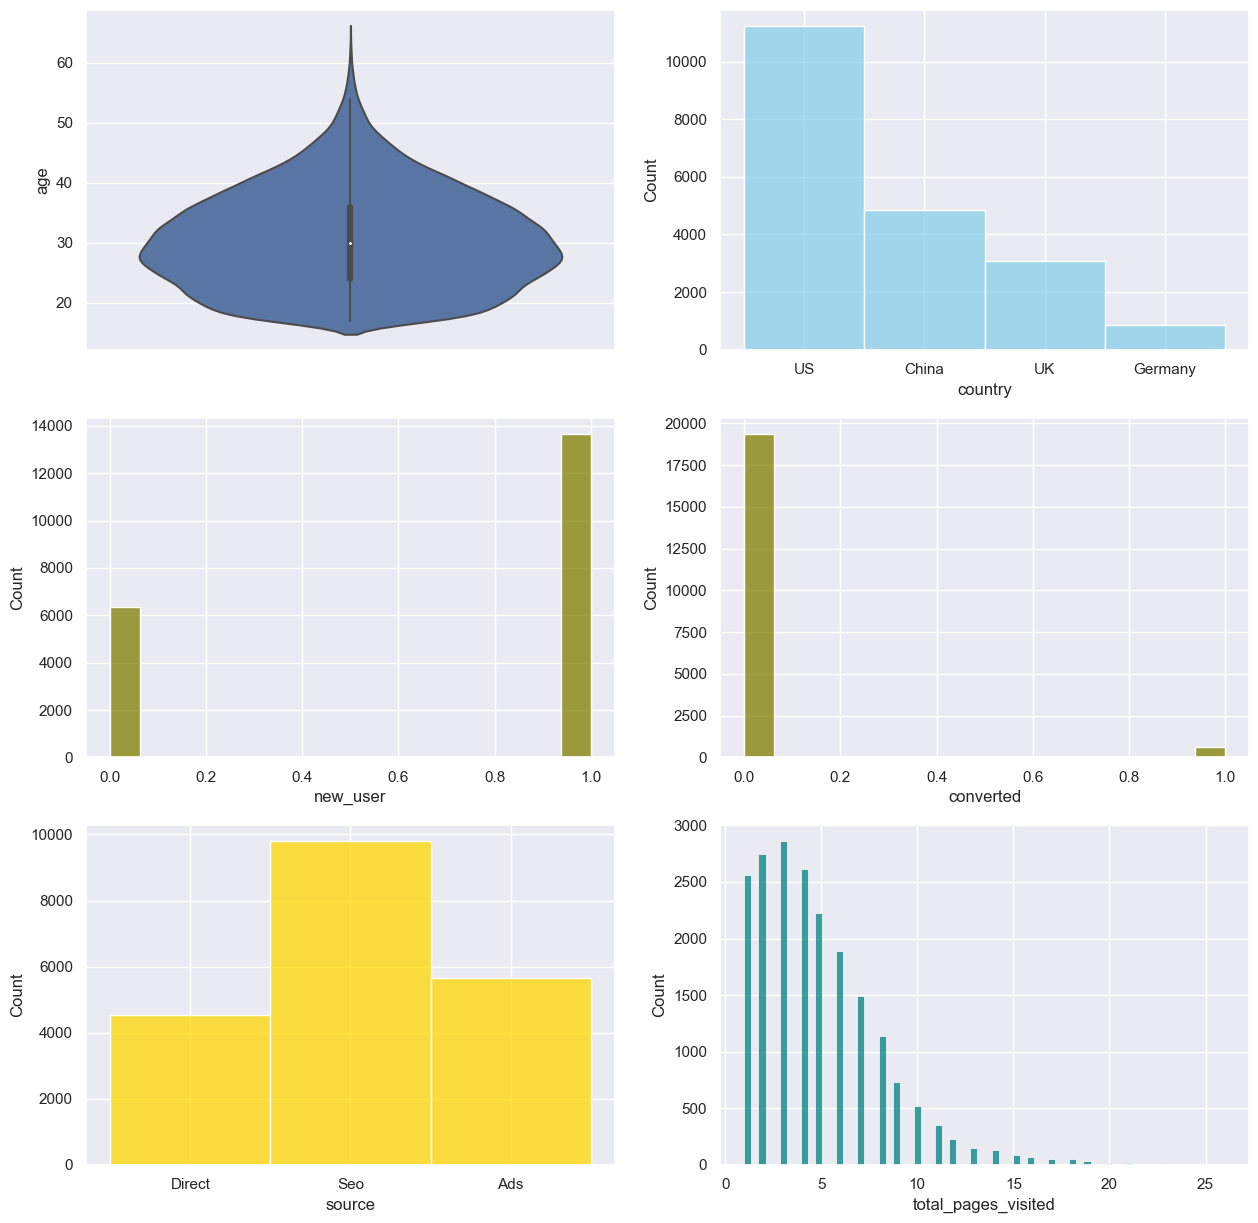

In [9]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.violinplot(y=df_train["age"], ax=axs[0, 0])
sns.histplot(data=df_train, x="country", color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_train, x="new_user", color="olive", ax=axs[1, 0])
sns.histplot(data=df_train, x="converted", color="olive", ax=axs[1, 1])
sns.histplot(data=df_train, x="source",  color="gold", ax=axs[2, 0])
sns.histplot(data=df_train, x="total_pages_visited", color="teal", ax=axs[2, 1])

plt.show()

<Axes: >

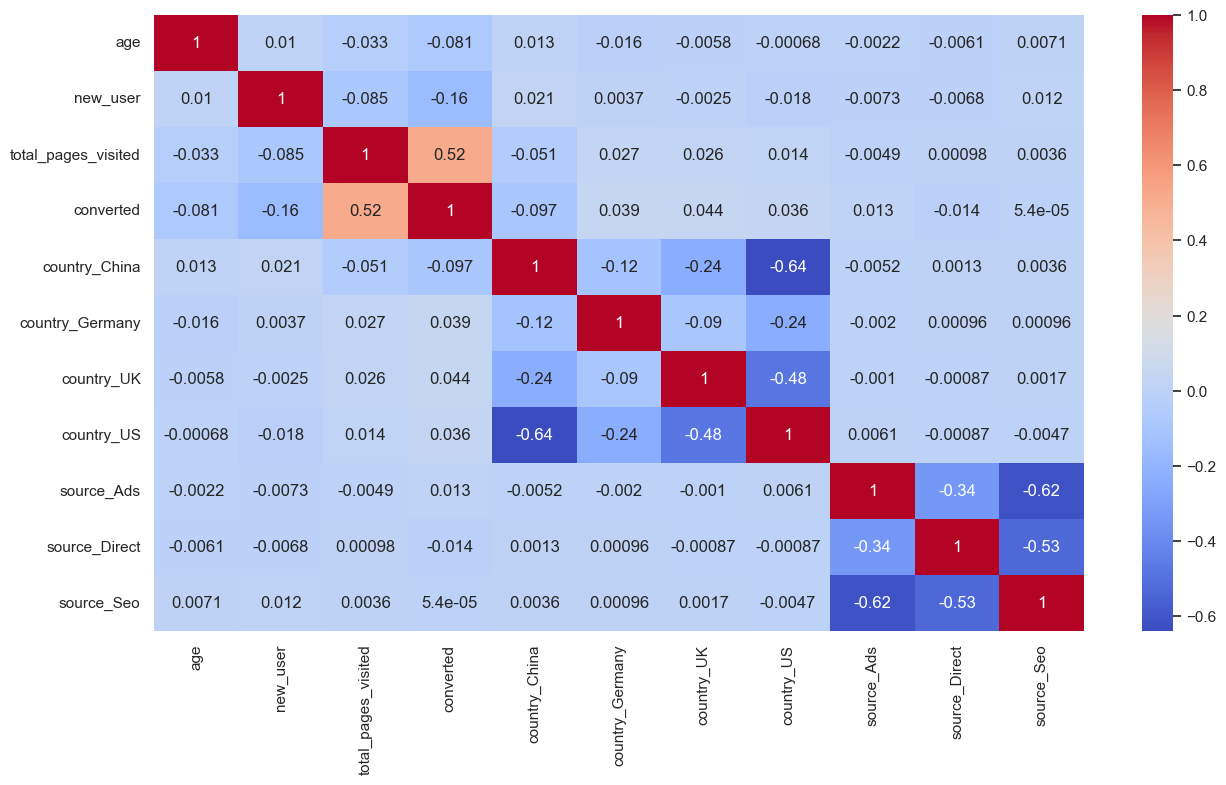

In [10]:
df_encoded = pd.get_dummies(df_train, columns=['country', 'source'])
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## 2-Preprocessing

2.1-df_train

In [11]:
# Separate target variable Y from features X
target_name = 'converted'

#print("Separating labels from features...")
Y = df_train.loc[:,target_name]
X = df_train.drop(target_name, axis = 1)
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

...Done.
75554     0
209519    0
146351    0
67397     0
115669    0
Name: converted, dtype: int64

       country  age  new_user  source  total_pages_visited
75554       US   24         0  Direct                    1
209519      US   29         1     Seo                    3
146351      US   32         0     Seo                    8
67397       US   38         0  Direct                    5
115669      US   24         1     Seo                    1



In [12]:
#Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [13]:
#Train test split
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify= Y)
print("...Done.")

Dividing into train and test sets...
...Done.


In [14]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [15]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

# Encode target variable Y
labelencoder = LabelEncoder()

print("Encoding labels on train set...")
print(Y_train.head())
print()
Y_train = labelencoder.fit_transform(Y_train)
print("...Done.")
print(Y_train[0:5])
print()

print("Encoding labels on test set...")
print(Y_test.head())
print()
Y_test = labelencoder.transform(Y_test)
print("...Done.")
print(Y_test[0:5])
print()

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
138800      US   17         1  Direct                    3
210130      US   34         1     Seo                    6
164144   China   28         1  Direct                    4
213227      US   39         1     Ads                    2
246104      US   31         0  Direct                    7
...Done.
[[-1.64035876  0.68408104 -0.56054677  0.          0.          1.
   1.          0.        ]
 [ 0.41091925  0.68408104  0.33725151  0.          0.          1.
   0.          1.        ]
 [-0.31306122  0.68408104 -0.26128067  0.          0.          0.
   1.          0.        ]
 [ 1.01423631  0.68408104 -0.85981286  0.          0.          1.
   0.          0.        ]
 [ 0.04892901 -1.46181511  0.6365176   0.          0.          1.
   1.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
49408       UK   26         

2.2-df_test

In [16]:
#Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in df_test.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source', 'converted']


In [17]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [18]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
df_test_preprocess = preprocessor.fit_transform(df_test)
print('...Done.')
print(df_test_preprocess[0:5])
print()


Performing preprocessings on train set...
...Done.
[[-0.31512217 -1.47663353  3.33913917  0.          1.          0.
   0.          1.        ]
 [-1.03657046  0.6772161   0.03888347  0.          1.          0.
   1.          0.        ]
 [ 0.16584336  0.6772161  -1.16120951  0.          0.          0.
   0.          1.        ]
 [ 0.16584336  0.6772161   0.33890671  0.          0.          1.
   0.          0.        ]
 [-0.67584631 -1.47663353 -0.56116302  0.          0.          0.
   0.          1.        ]]



## 3-Model Training

### 3.1- Logistic Regression

3.1.1- Model

In [19]:
# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


3.1.2- Performance assesment

In [20]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99672393e-01 3.27607419e-04]
 [9.99111174e-01 8.88826254e-04]
 [9.99968968e-01 3.10317838e-05]
 ...
 [9.99974487e-01 2.55128079e-05]
 [9.99657685e-01 3.42314628e-04]
 [9.99870511e-01 1.29488665e-04]]



In [21]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()


Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[7.96406530e-01 2.03593470e-01]
 [9.91104446e-01 8.89555384e-03]
 [9.98309438e-01 1.69056154e-03]
 ...
 [9.99998427e-01 1.57304164e-06]
 [9.99728883e-01 2.71117011e-04]
 [9.00920127e-01 9.90798725e-02]]



In [22]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()


accuracy on training set :  0.9866428571428572
accuracy on test set :  0.9858333333333333

f1-score on training set :  0.763590391908976
f1-score on test set :  0.743202416918429



3.1.3- Confusion matrix and ROC Curve

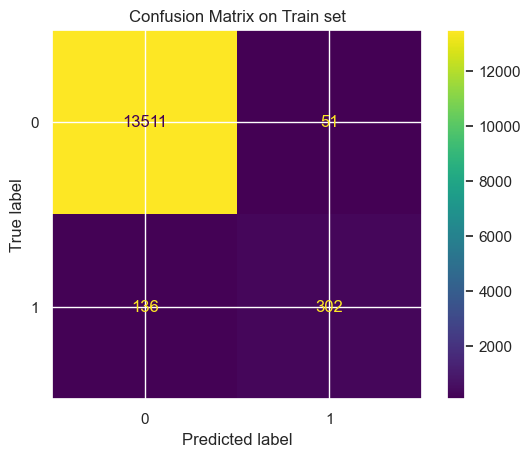

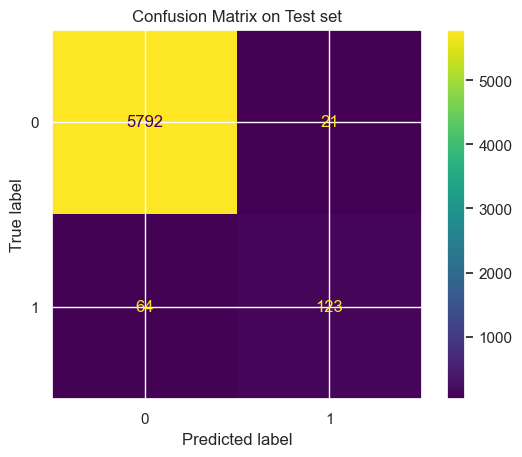

In [23]:
# Visualize confusion matrices
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()



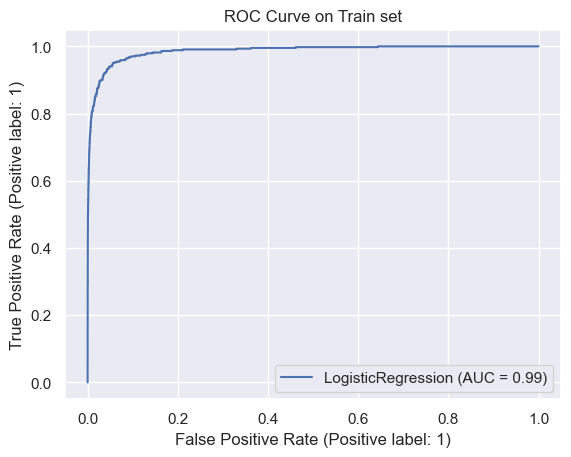

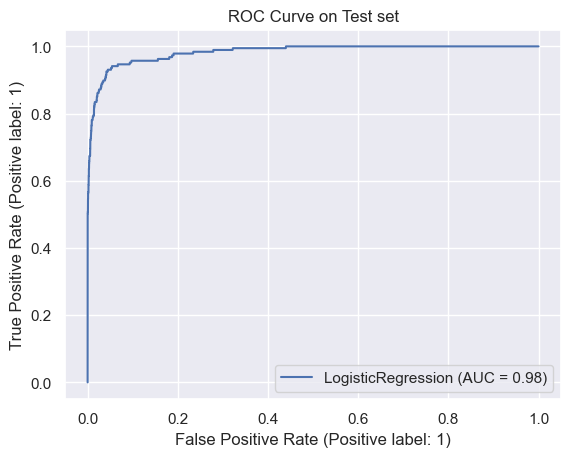

In [24]:
# Visualize ROC curves
_ , ax = plt.subplots()
ax.set(title="ROC Curve on Train set")
RocCurveDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="ROC Curve on Test set")
RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()



3.1.4-Gridsearch

In [25]:
# Creating the hyperparameter grid
param_grid = {
    'penalty': ['l2', None],
    'C': [0.1, 1, 10, 100]
}

# Instantiating logistic regression classifier
logreg = LogisticRegression(solver = 'lbfgs')
 
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
 
logreg_cv.fit(X_train, Y_train)
 
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages

Tuned Logistic Regression Parameters: {'C': 0.1, 'penalty': None}
Best score is 0.9867857142857142


d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


3.1.5- Test sur df_test

In [26]:
# Train model
model = LogisticRegression(penalty = None, C=0.1)

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Training model...
...Done.


In [27]:
# Predictions on training set
print("Predictions on training set...")
Y_test_pred = model.predict(df_test_preprocess)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1 0 0 ... 0 0 0]



In [28]:
df_test['converted'] = Y_test_pred
df_test.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,28,0,Seo,16,1
1,UK,22,1,Direct,5,0
2,China,32,1,Seo,1,0
3,US,32,1,Ads,6,0
4,China,25,0,Seo,3,0


### 3.2- Random Forest Classifier

3.2.1- Model

In [29]:
# Train model
model = RandomForestClassifier()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...


...Done.


In [30]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]



In [31]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.63       0.37      ]
 [1.         0.        ]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.96666667 0.03333333]]



In [32]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9959285714285714
accuracy on test set :  0.981

f1-score on training set :  0.9320619785458879
f1-score on test set :  0.6868131868131868



3.2.2-Confusion matrix and ROC curve

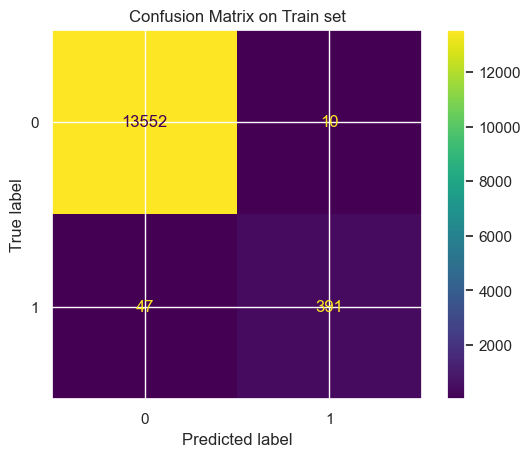

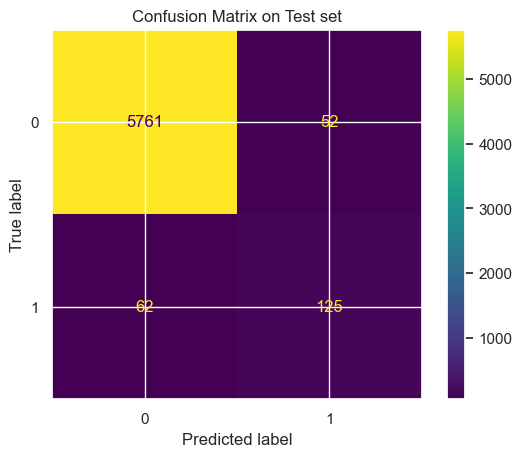

In [33]:
# Visualize confusion matrices
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()

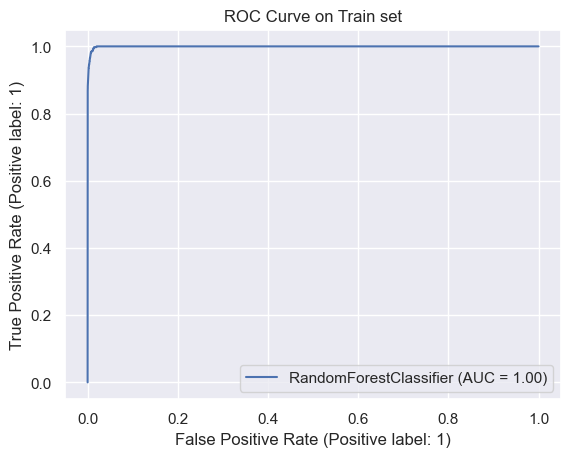

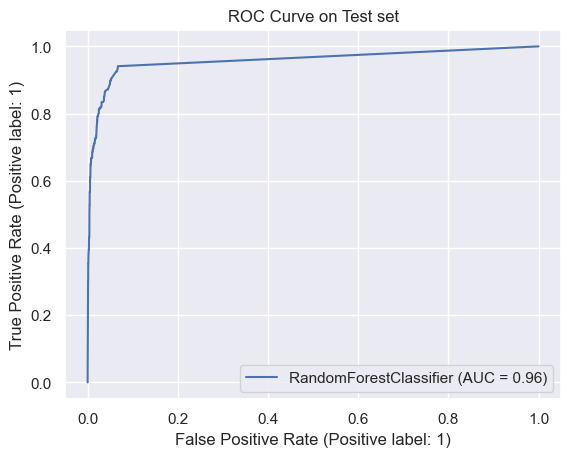

In [34]:
# Visualize ROC curves
_ , ax = plt.subplots()
ax.set(title="ROC Curve on Train set")
RocCurveDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="ROC Curve on Test set")
RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()

3.2.3-Grid search

In [35]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]}

forest = RandomForestClassifier()

forest_cv = GridSearchCV(forest,
                           param_grid=param_grid)

forest_cv.fit(X_train, Y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Random Forest Parameters: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 50}
Best score is 0.9847142857142857


3.2.4 Test on df_test

In [40]:
# Train model
model = RandomForestClassifier(n_estimators=50, max_depth= 9, max_features= None, max_leaf_nodes= 9)

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...


...Done.


In [41]:
# Predictions on training set
print("Predictions on training set...")
Y_test_pred = model.predict(df_test_preprocess)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1 0 0 ... 0 0 0]



In [42]:
df_test['converted'] = Y_test_pred
df_test.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,28,0,Seo,16,1
1,UK,22,1,Direct,5,0
2,China,32,1,Seo,1,0
3,US,32,1,Ads,6,0
4,China,25,0,Seo,3,0


### 3.3- Xgboost

3.3.1- Model


In [39]:
# Train model
model = XGBClassifier()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...


...Done.


In [43]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[0.9955506 0.0044494]
 [0.9955506 0.0044494]
 [0.9955506 0.0044494]
 ...
 [0.9955506 0.0044494]
 [0.9955506 0.0044494]
 [0.9955506 0.0044494]]



In [44]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.93471296 0.06528704]
 [0.9955506  0.0044494 ]
 [0.9955506  0.0044494 ]
 ...
 [0.9955506  0.0044494 ]
 [0.9955506  0.0044494 ]
 [0.95903942 0.04096058]]



In [45]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9862857142857143
accuracy on test set :  0.9835

f1-score on training set :  0.7581863979848866
f1-score on test set :  0.7009063444108762



3.3.2- Confusion matrix et ROC curve

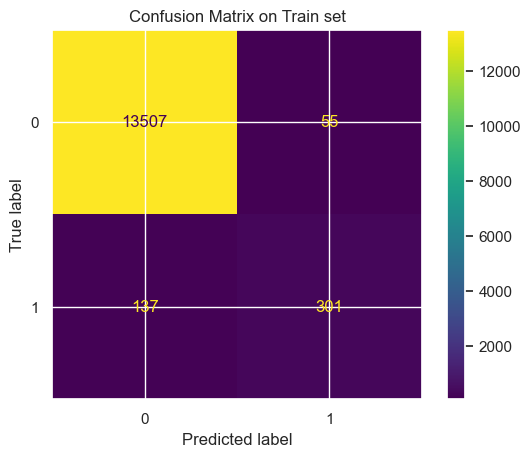

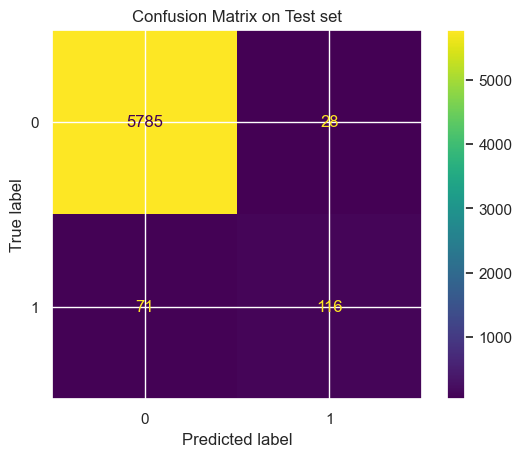

In [46]:
# Visualize confusion matrices
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()

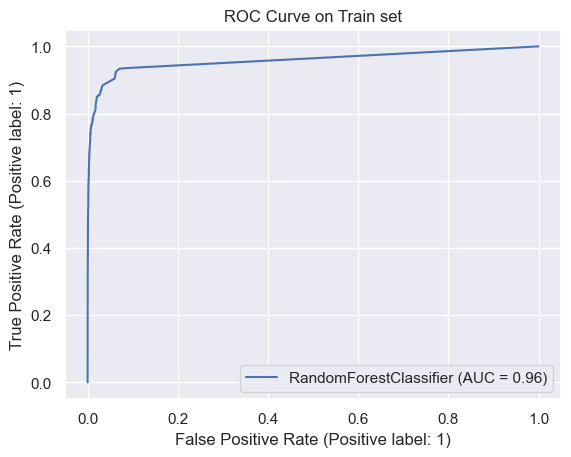

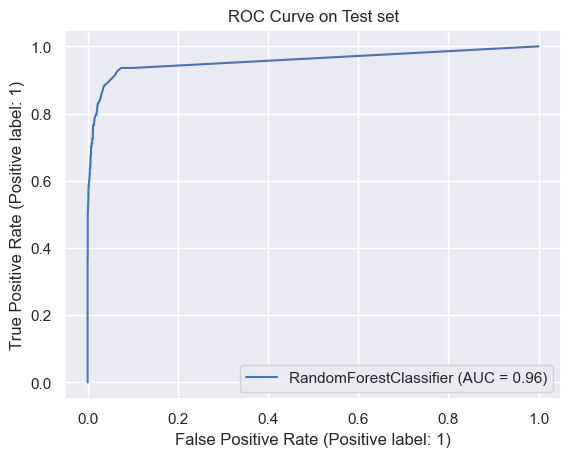

In [47]:
# Visualize ROC curves
_ , ax = plt.subplots()
ax.set(title="ROC Curve on Train set")
RocCurveDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="ROC Curve on Test set")
RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()

3.3.3- Grid search

In [48]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [2, 4, 6, 8,]
}
print(params)
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
{'max_depth': [2, 4, 6], 'min_child_weight': [1, 2, 3], 'n_estimators': [2, 4, 6, 8]}
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 2}
Best validation accuracy :  0.9855000712857048


3.3.4- Test sur df_test

In [49]:
# Train model
model = XGBClassifier(max_depth=6, min_child_weight=1, n_estimators=2)

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


In [50]:
# Predictions on training set
print("Predictions on training set...")
Y_test_pred = model.predict(df_test_preprocess)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1 0 0 ... 0 1 0]



In [51]:
df_test['converted'] = Y_test_pred
df_test.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,28,0,Seo,16,1
1,UK,22,1,Direct,5,0
2,China,32,1,Seo,1,0
3,US,32,1,Ads,6,0
4,China,25,0,Seo,3,0
